In [3]:
import torch
from torch import nn as nn
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms

## 准备数据集

In [6]:
import torch.utils
import torch.utils.data


transform = transforms.Compose(
    [transforms.ToTensor(), #先转化为tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))] #并将其像素值归一化到 [0.0, 1.0] 范围
)
batch_size = 4

train_data = torchvision.datasets.CIFAR10(
    root='/Users/lihaibin/Workspace/dataset',
    train=True,
    download=True,
    transform=transform
)

test_data = torchvision.datasets.CIFAR10(
    root='/Users/lihaibin/Workspace/dataset',
    train=False,
    download=True,
    transform=transform
)

train_dataloder = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size=batch_size, num_workers=2)
# num_workers = 2表示2个进程来加载数据

100%|██████████| 170498071/170498071 [00:25<00:00, 6700686.55it/s]


Extracting /Users/lihaibin/Workspace/dataset/cifar-10-python.tar.gz to /Users/lihaibin/Workspace/dataset
Files already downloaded and verified


## 数据集可视化

/Users/lihaibin/anaconda3/envs/rl/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/lihaibin/anaconda3/envs/rl/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <DAC8FDCB-770B-356E-BA9C-E2F40A2AA20E> /Users/lihaibin/anaconda3/envs/rl/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <43889F86-100F-3086-90C3-D4AE08235BA7> /Users/lihaibin/anaconda3/envs/rl/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/lihaibin/anaconda3/envs/rl/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/lihaibin/anaconda3/envs/rl/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <DAC8FDCB-770B-356E-BA9C-E2F40A2AA20E> /Users/lihaibi

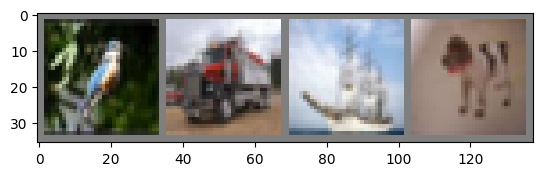

bird  truck ship  dog  


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloder)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 定义CNN

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

## Loss function

In [25]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.01)

## Train the Model

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloder, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

In [ ]:
epochs = 10
for epoch in range(epochs):
    train_loss = 0.0
    for i, data in enumerate(train_dataloder, 0):
        input, label = data

        optimizer.zero_grad()

        output = net(input)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        if i % 2000==1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {train_loss / 5000:.3f}')
            train_loss = 0.0
print("Done!")

In [16]:
model_path = "/Users/lihaibin/Workspace/dataset/cifar_net.pth"
torch.save(net.state_dict(), model_path)

## Test the Model

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')